In [302]:
import os
from typing import Union, Tuple
from math import ceil, sqrt
from torch.utils.data import SubsetRandomSampler, DataLoader

import torch
from torch import nn
import torch.nn.functional as F
from torch import package
from torch.nn import MSELoss, L1Loss, SmoothL1Loss
import torch.optim as optim
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.norm import LayerNorm, PairNorm, InstanceNorm
from torch_geometric.typing import PairTensor, Adj, OptTensor, Size
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.utils import softmax
from torch_geometric.nn.models.dimenet import BesselBasisLayer
from torch_scatter import scatter_add, scatter
import numpy as np
from scipy.special import comb
from deeph.data import HData

from deeph.from_se3_transformer import SphericalHarmonics
from deeph.from_schnetpack import GaussianBasis
from deeph.from_PyG_future import GraphNorm, DiffGroupNorm
from deeph.from_HermNet import RBF, cosine_cutoff, ShiftedSoftplus, _eps
from inspect import signature

from deeph.utils import LossRecord

In [303]:
class CGConv(MessagePassing):
    def __init__(self, channels: Union[int, Tuple[int, int]], dim: int = 0,
                 aggr: str = 'add', normalization: str = None,
                 bias: bool = True, if_exp: bool = False, **kwargs):
        super(CGConv, self).__init__(aggr=aggr, flow="source_to_target", **kwargs)
        self.channels = channels
        self.dim = dim
        self.normalization = normalization
        self.if_exp = if_exp

        if isinstance(channels, int):
            channels = (channels, channels)

        self.lin_f = nn.Linear(sum(channels) + dim, channels[1], bias=bias)
        self.lin_s = nn.Linear(sum(channels) + dim, channels[1], bias=bias)
        if self.normalization == 'BatchNorm':
            self.bn = nn.BatchNorm1d(channels[1], track_running_stats=True)
        elif self.normalization == 'LayerNorm':
            self.ln = LayerNorm(channels[1])
        elif self.normalization == 'PairNorm':
            self.pn = PairNorm(channels[1])
        elif self.normalization == 'InstanceNorm':
            self.instance_norm = InstanceNorm(channels[1])
        elif self.normalization == 'GraphNorm':
            self.gn = GraphNorm(channels[1])
        elif self.normalization == 'DiffGroupNorm':
            self.group_norm = DiffGroupNorm(channels[1], 128)
        elif self.normalization is None:
            pass
        else:
            raise ValueError('Unknown normalization function: {}'.format(normalization))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_f.reset_parameters()
        self.lin_s.reset_parameters()
        if self.normalization == 'BatchNorm':
            self.bn.reset_parameters()

    def forward(self, x: Union[torch.Tensor, PairTensor], edge_index: Adj,
                edge_attr: OptTensor, batch, distance, size: Size = None) -> torch.Tensor:
        """"""
        if isinstance(x, torch.Tensor):
            x: PairTensor = (x, x)

        # propagate_type: (x: PairTensor, edge_attr: OptTensor)
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, distance=distance, size=size)
        if self.normalization == 'BatchNorm':
            out = self.bn(out)
        elif self.normalization == 'LayerNorm':
            out = self.ln(out, batch)
        elif self.normalization == 'PairNorm':
            out = self.pn(out, batch)
        elif self.normalization == 'InstanceNorm':
            out = self.instance_norm(out, batch)
        elif self.normalization == 'GraphNorm':
            out = self.gn(out, batch)
        elif self.normalization == 'DiffGroupNorm':
            out = self.group_norm(out)
        out += x[1]
        return out

    def message(self, x_i, x_j, edge_attr: OptTensor, distance) -> torch.Tensor:
        z = torch.cat([x_i, x_j, edge_attr], dim=-1)
        out = self.lin_f(z).sigmoid() * F.softplus(self.lin_s(z))
        if self.if_exp: # Very specific section. The message is scaled exponentially with the distance.
            sigma = 3
            n = 2
            out = out * torch.exp(-distance ** n / sigma ** n / 2).view(-1, 1)
        return out

    def __repr__(self):
        return '{}({}, dim={})'.format(self.__class__.__name__, self.channels, self.dim)

In [304]:
class MPLayer(nn.Module):
    def __init__(self, in_atom_fea_len, in_edge_fea_len, out_edge_fea_len, if_exp, if_edge_update, normalization,
                 atom_update_net, gauss_stop, output_layer=False):
        super(MPLayer, self).__init__()
        if atom_update_net == 'CGConv':
            self.cgconv = CGConv(channels=in_atom_fea_len,
                                 dim=in_edge_fea_len,
                                 aggr='add',
                                 normalization=normalization,
                                 if_exp=if_exp)

        self.if_edge_update = if_edge_update
        self.atom_update_net = atom_update_net
        if if_edge_update:
            if output_layer:
                self.e_lin = nn.Sequential(nn.Linear(in_edge_fea_len + in_atom_fea_len * 2, 128),
                                           nn.SiLU(),
                                           nn.Linear(128, out_edge_fea_len),
                                           )
            else:
                self.e_lin = nn.Sequential(nn.Linear(in_edge_fea_len + in_atom_fea_len * 2, 128),
                                           nn.SiLU(),
                                           nn.Linear(128, out_edge_fea_len),
                                           nn.SiLU(),
                                           )

    def forward(self, atom_fea, edge_idx, edge_fea, batch, distance, edge_vec):
        atom_fea = self.cgconv(atom_fea, edge_idx, edge_fea, batch, distance)
        atom_fea_s = atom_fea
        if self.if_edge_update:
            row, col = edge_idx
            edge_fea = self.e_lin(torch.cat([atom_fea_s[row], atom_fea_s[col], edge_fea], dim=-1))
            return atom_fea, edge_fea
        else:
            return atom_fea

In [305]:
class LCMPLayer(nn.Module):
    def __init__(self, in_atom_fea_len, in_edge_fea_len, out_edge_fea_len, num_l,
                 normalization: str = None, bias: bool = True, if_exp: bool = False):
        super(LCMPLayer, self).__init__()
        self.in_atom_fea_len = in_atom_fea_len
        self.normalization = normalization
        self.if_exp = if_exp

        self.lin_f = nn.Linear(in_atom_fea_len * 2 + in_edge_fea_len, in_atom_fea_len, bias=bias)
        self.lin_s = nn.Linear(in_atom_fea_len * 2 + in_edge_fea_len, in_atom_fea_len, bias=bias)
        self.bn = nn.BatchNorm1d(in_atom_fea_len, track_running_stats=True)

        self.e_lin = nn.Sequential(nn.Linear(in_edge_fea_len + in_atom_fea_len * 2 - num_l ** 2, 128),
                                   nn.SiLU(),
                                   nn.Linear(128, out_edge_fea_len)
                                   )
        self.final_linear = nn.Linear(out_edge_fea_len, 999)  # New linear layer to reduce to a single number

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_f.reset_parameters()
        self.lin_s.reset_parameters()
        if self.normalization == 'BatchNorm':
            self.bn.reset_parameters()
        self.final_linear.reset_parameters()

    def forward(self, atom_fea, edge_fea, sub_atom_idx, sub_edge_idx, sub_edge_ang, sub_index, distance,
                huge_structure, output_final_layer_neuron):
        if huge_structure:
            sub_graph_batch_num = 8

            sub_graph_num = sub_atom_idx.shape[0]
            sub_graph_batch_size = ceil(sub_graph_num / sub_graph_batch_num)

            num_edge = edge_fea.shape[0]
            vf_update = torch.zeros((num_edge * 2, self.in_atom_fea_len)).type(torch.get_default_dtype()).to(atom_fea.device)
            for sub_graph_batch_index in range(sub_graph_batch_num):
                if sub_graph_batch_index == sub_graph_batch_num - 1:
                    sub_graph_idx = slice(sub_graph_batch_size * sub_graph_batch_index, sub_graph_num)
                else:
                    sub_graph_idx = slice(sub_graph_batch_size * sub_graph_batch_index,
                                          sub_graph_batch_size * (sub_graph_batch_index + 1))

                sub_atom_idx_batch = sub_atom_idx[sub_graph_idx]
                sub_edge_idx_batch = sub_edge_idx[sub_graph_idx]
                sub_edge_ang_batch = sub_edge_ang[sub_graph_idx]
                sub_index_batch = sub_index[sub_graph_idx]

                z = torch.cat([atom_fea[sub_atom_idx_batch][:, 0, :], atom_fea[sub_atom_idx_batch][:, 1, :],
                               edge_fea[sub_edge_idx_batch], sub_edge_ang_batch], dim=-1)
                out = self.lin_f(z).sigmoid() * F.softplus(self.lin_s(z))

                if self.if_exp:
                    sigma = 3
                    n = 2
                    out = out * torch.exp(-distance[sub_edge_idx_batch] ** n / sigma ** n / 2).view(-1, 1)

                vf_update += scatter_add(out, sub_index_batch, dim=0, dim_size=num_edge * 2)

            if self.normalization == 'BatchNorm':
                vf_update = self.bn(vf_update)
            vf_update = vf_update.reshape(num_edge, 2, -1)
            if output_final_layer_neuron != '':
                final_layer_neuron = torch.cat([vf_update[:, 0, :], vf_update[:, 1, :], edge_fea],
                                               dim=-1).detach().cpu().numpy()
                np.save(os.path.join(output_final_layer_neuron, 'final_layer_neuron.npy'), final_layer_neuron)
            out = self.e_lin(torch.cat([vf_update[:, 0, :], vf_update[:, 1, :], edge_fea], dim=-1))

            return out

        num_edge = edge_fea.shape[0]
        z = torch.cat(
            [atom_fea[sub_atom_idx][:, 0, :], atom_fea[sub_atom_idx][:, 1, :], edge_fea[sub_edge_idx], sub_edge_ang],
            dim=-1)
        out = self.lin_f(z).sigmoid() * F.softplus(self.lin_s(z))

        if self.if_exp:
            sigma = 3
            n = 2
            out = out * torch.exp(-distance[sub_edge_idx] ** n / sigma ** n / 2).view(-1, 1)

        out = scatter_add(out, sub_index, dim=0)
        if self.normalization == 'BatchNorm':
            out = self.bn(out)
        out = out.reshape(num_edge, 2, -1)
        if output_final_layer_neuron != '':
            final_layer_neuron = torch.cat([out[:, 0, :], out[:, 1, :], edge_fea], dim=-1).detach().cpu().numpy()
            np.save(os.path.join(output_final_layer_neuron, 'final_layer_neuron.npy'), final_layer_neuron)
        out = self.e_lin(torch.cat([out[:, 0, :], out[:, 1, :], edge_fea], dim=-1))

        # Aggregate over all edges to produce a single number
        out = out.mean(dim=0, keepdim=True)  # Aggregating over num_edge
        out = self.final_linear(out)  # Final linear layer to produce a single number
        
        out = out.squeeze(0)
        return out

In [306]:
class MultipleLinear(nn.Module):
    def __init__(self, num_linear: int, in_fea_len: int, out_fea_len: int, bias: bool = True) -> None:
        super(MultipleLinear, self).__init__()
        self.num_linear = num_linear
        self.out_fea_len = out_fea_len
        self.weight = nn.Parameter(torch.Tensor(num_linear, in_fea_len, out_fea_len))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(num_linear, out_fea_len))
        else:
            self.register_parameter('bias', None)
        # self.ln = LayerNorm(num_linear * out_fea_len)
        # self.gn = GraphNorm(out_fea_len)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.weight, a=sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input: torch.Tensor, batch_edge: torch.Tensor) -> torch.Tensor:
        output = torch.matmul(input, self.weight)

        if self.bias is not None:
            output += self.bias[:, None, :]
        return output

In [307]:
class HGNN(nn.Module):
    def __init__(self, num_species, in_atom_fea_len, in_edge_fea_len, num_orbital,
                 distance_expansion, gauss_stop, if_exp, if_MultipleLinear, if_edge_update, if_lcmp,
                 normalization, atom_update_net, separate_onsite,
                 trainable_gaussians, type_affine, num_l=5):
        super(HGNN, self).__init__()
        self.num_species = num_species
        self.embed = nn.Embedding(num_species + 5, in_atom_fea_len)

        # pair-type aware affine
        if type_affine:
            self.type_affine = nn.Embedding(
                num_species ** 2, 2,
                _weight=torch.stack([torch.ones(num_species ** 2), torch.zeros(num_species ** 2)], dim=-1)
            )
        else:
            self.type_affine = None

        if if_edge_update or (if_edge_update is False and if_lcmp is False):
            distance_expansion_len = in_edge_fea_len
        else:
            distance_expansion_len = in_edge_fea_len - num_l ** 2
        if distance_expansion == 'GaussianBasis':
            self.distance_expansion = GaussianBasis(
                0.0, gauss_stop, distance_expansion_len, trainable=trainable_gaussians
            )

        self.if_MultipleLinear = if_MultipleLinear
        self.if_edge_update = if_edge_update
        self.if_lcmp = if_lcmp
        self.atom_update_net = atom_update_net
        self.separate_onsite = separate_onsite

        if if_lcmp == True:
            mp_output_edge_fea_len = in_edge_fea_len - num_l ** 2
        else:
            assert if_MultipleLinear == False
            mp_output_edge_fea_len = in_edge_fea_len

        if if_edge_update == True:
            self.mp1 = MPLayer(in_atom_fea_len, in_edge_fea_len, in_edge_fea_len, if_exp, if_edge_update, normalization,
                               atom_update_net, gauss_stop)
            self.mp2 = MPLayer(in_atom_fea_len, in_edge_fea_len, in_edge_fea_len, if_exp, if_edge_update, normalization,
                               atom_update_net, gauss_stop)
            self.mp3 = MPLayer(in_atom_fea_len, in_edge_fea_len, in_edge_fea_len, if_exp, if_edge_update, normalization,
                               atom_update_net, gauss_stop)
            self.mp4 = MPLayer(in_atom_fea_len, in_edge_fea_len, in_edge_fea_len, if_exp, if_edge_update, normalization,
                               atom_update_net, gauss_stop)
            self.mp5 = MPLayer(in_atom_fea_len, in_edge_fea_len, mp_output_edge_fea_len, if_exp, if_edge_update,
                               normalization, atom_update_net, gauss_stop)
        else:
            self.mp1 = MPLayer(in_atom_fea_len, distance_expansion_len, None, if_exp, if_edge_update, normalization,
                               atom_update_net, gauss_stop)
            self.mp2 = MPLayer(in_atom_fea_len, distance_expansion_len, None, if_exp, if_edge_update, normalization,
                               atom_update_net, gauss_stop)
            self.mp3 = MPLayer(in_atom_fea_len, distance_expansion_len, None, if_exp, if_edge_update, normalization,
                               atom_update_net, gauss_stop)
            self.mp4 = MPLayer(in_atom_fea_len, distance_expansion_len, None, if_exp, if_edge_update, normalization,
                               atom_update_net, gauss_stop)
            self.mp5 = MPLayer(in_atom_fea_len, distance_expansion_len, None, if_exp, if_edge_update, normalization,
                               atom_update_net, gauss_stop)

        if if_lcmp == True:
            if self.if_MultipleLinear == True:
                self.lcmp = LCMPLayer(in_atom_fea_len, in_edge_fea_len, 32, num_l, if_exp=if_exp)
                self.multiple_linear1 = MultipleLinear(num_orbital, 32, 16)
                self.multiple_linear2 = MultipleLinear(num_orbital, 16, 1)
            else:
                self.lcmp = LCMPLayer(in_atom_fea_len, in_edge_fea_len, num_orbital, num_l, if_exp=if_exp)
        else:
            self.mp_output = MPLayer(in_atom_fea_len, in_edge_fea_len, num_orbital, if_exp, if_edge_update=True,
                                     normalization=normalization, atom_update_net=atom_update_net,
                                     gauss_stop=gauss_stop, output_layer=True)


    def forward(self, atom_attr, edge_idx, edge_attr, batch,
                sub_atom_idx=None, sub_edge_idx=None, sub_edge_ang=None, sub_index=None,
                huge_structure=False, output_final_layer_neuron=''):
        batch_edge = batch[edge_idx[0]]
        atom_fea0 = self.embed(atom_attr)
        distance = edge_attr[:, 0]
        edge_vec = edge_attr[:, 1:4] - edge_attr[:, 4:7]
        if self.type_affine is None:
            edge_fea0 = self.distance_expansion(distance)
        else:
            affine_coeff = self.type_affine(self.num_species * atom_attr[edge_idx[0]] + atom_attr[edge_idx[1]])
            edge_fea0 = self.distance_expansion(distance * affine_coeff[:, 0] + affine_coeff[:, 1])

        if self.if_edge_update == True:
            atom_fea, edge_fea = self.mp1(atom_fea0, edge_idx, edge_fea0, batch, distance, edge_vec)
            atom_fea, edge_fea = self.mp2(atom_fea, edge_idx, edge_fea, batch, distance, edge_vec)
            atom_fea0, edge_fea0 = atom_fea0 + atom_fea, edge_fea0 + edge_fea
            atom_fea, edge_fea = self.mp3(atom_fea0, edge_idx, edge_fea0, batch, distance, edge_vec)
            atom_fea, edge_fea = self.mp4(atom_fea, edge_idx, edge_fea, batch, distance, edge_vec)
            atom_fea0, edge_fea0 = atom_fea0 + atom_fea, edge_fea0 + edge_fea
            atom_fea, edge_fea = self.mp5(atom_fea0, edge_idx, edge_fea0, batch, distance, edge_vec)

            if self.if_lcmp == True:
                if self.atom_update_net == 'PAINN':
                    atom_fea_s = atom_fea.node_fea_s
                else:
                    atom_fea_s = atom_fea
                out = self.lcmp(atom_fea_s, edge_fea, sub_atom_idx, sub_edge_idx, sub_edge_ang, sub_index, distance,
                                huge_structure, output_final_layer_neuron)
            else:
                atom_fea, edge_fea = self.mp_output(atom_fea, edge_idx, edge_fea, batch, distance, edge_vec)
                out = edge_fea
        else:
            atom_fea = self.mp1(atom_fea0, edge_idx, edge_fea0, batch, distance, edge_vec)
            atom_fea = self.mp2(atom_fea, edge_idx, edge_fea0, batch, distance, edge_vec)
            atom_fea0 = atom_fea0 + atom_fea
            atom_fea = self.mp3(atom_fea0, edge_idx, edge_fea0, batch, distance, edge_vec)
            atom_fea = self.mp4(atom_fea, edge_idx, edge_fea0, batch, distance, edge_vec)
            atom_fea0 = atom_fea0 + atom_fea
            atom_fea = self.mp5(atom_fea0, edge_idx, edge_fea0, batch, distance, edge_vec)

            if self.atom_update_net == 'PAINN':
                atom_fea_s = atom_fea.node_fea_s
            else:
                atom_fea_s = atom_fea
            if self.if_lcmp == True:
                out = self.lcmp(atom_fea_s, edge_fea0, sub_atom_idx, sub_edge_idx, sub_edge_ang, sub_index, distance,
                                huge_structure, output_final_layer_neuron)
            else:
                atom_fea, edge_fea = self.mp_output(atom_fea, edge_idx, edge_fea0, batch, distance, edge_vec)
                out = edge_fea

        if self.if_MultipleLinear == True:
            out = self.multiple_linear1(F.silu(out), batch_edge)
            out = self.multiple_linear2(F.silu(out), batch_edge)
            out = out.T

        return out    

In [308]:
dataset = HData(
    raw_data_dir='/home/t.hsu/example2/work_dir/dataset/processed',
    graph_dir='/home/t.hsu/example2/work_dir/dataset/graph',
    interface='h5',
    target='hamiltonian',
    dataset_name='Bi_soc',
    multiprocessing=0,
    radius='-1.0',
    max_num_nbr=0,
    num_l='5',
    max_element='-1',
    create_from_DFT='True',
    if_lcmp_graph='True',
    separate_onsite='False',
    new_sp=False,
    default_dtype_torch=torch.get_default_dtype(),
)

In [309]:
import configparser
import json
from deeph.kernel import DeepHKernel
# Initialize the ConfigParser
config = configparser.ConfigParser()

# Read the configuration file
config.read('/home/t.hsu/deeph_dev/default.ini')

config.read('/home/t.hsu/deeph_dev/train.ini')  # Replace 'config.ini' with your actual file name
kernel = DeepHKernel(config)
_, _, _, _ = kernel.get_dataset()
num_species = len(dataset.info["index_to_Z"])
orbital = json.loads(config.get('basic', 'orbital'))
num_orbital = len(orbital)
spinful = True
if_lcmp = True
separate_onsite = False
if spinful:
    out_fea_len = num_orbital * 8
else:
    out_fea_len = num_orbital
print('DeepH', out_fea_len)
out_fea_len = 999
print('DOS', out_fea_len)

In [310]:
model_kwargs = dict(
    n_elements=num_species,
    num_species=num_species,
    in_atom_fea_len=config.getint('network', 'atom_fea_len'),
    in_vfeats=config.getint('network', 'atom_fea_len'),
    in_edge_fea_len=config.getint('network', 'edge_fea_len'),
    in_efeats=config.getint('network', 'edge_fea_len'),
    out_edge_fea_len=out_fea_len,
    out_efeats=out_fea_len,
    num_orbital=out_fea_len,
    distance_expansion=config.get('network', 'distance_expansion'),
    gauss_stop=config.getfloat('network', 'gauss_stop'),
    cutoff=config.getfloat('network', 'gauss_stop'),
    if_exp=config.getboolean('network', 'if_exp'),
    if_MultipleLinear=config.getboolean('network', 'if_MultipleLinear'),
    if_edge_update=config.getboolean('network', 'if_edge_update'),
    if_lcmp=if_lcmp,
    normalization=config.get('network', 'normalization'),
    atom_update_net=config.get('network', 'atom_update_net', fallback='CGConv'),
    separate_onsite=separate_onsite,
    num_l=config.getint('network', 'num_l'),
    trainable_gaussians=config.getboolean('network', 'trainable_gaussians', fallback=False),
    type_affine=config.getboolean('network', 'type_affine', fallback=False),
    if_fc_out=False,
)
parameter_list = list(signature(HGNN.__init__).parameters.keys())
current_parameter_list = list(model_kwargs.keys())
for k in current_parameter_list:
    if k not in parameter_list:
        model_kwargs.pop(k)
if 'num_elements' in parameter_list:
    model_kwargs['num_elements'] = config.getint('basic', 'max_element') + 1
model = HGNN(**model_kwargs)

In [311]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("The model you built has: %d parameters" % params)


In [312]:
device = torch.device(config.get('basic', 'device') if torch.cuda.is_available() else 'cpu')
model.to(device)
torch.cuda.is_available()


True

In [313]:
def make_mask(dataset):
    spinful = True
    target = 'hamiltonian'
    num_orbital = kernel.num_orbital
    dataset_mask = []
    for i, data in enumerate(dataset):
        # filename = '/home/t.hsu/DeepRFnet/DeepDOS/work_dir/dataset/raw/{}/openmx.DOS.Gaussian'.format(i)
        # aux = np.loadtxt(filename)

        # dos = torch.tensor(aux[:,1], dtype=torch.float32)  # Convert to tensor if not already
        # dos = dos.view(-1)
        Oij_value = data.term_real
        if data.term_real is not None:
            if_only_rc = False

        if spinful:
            out_fea_len = num_orbital * 8
            # out_fea_len = 999
            
        mask = torch.zeros(data.edge_attr.shape[0], out_fea_len, dtype=torch.int8)
        label = torch.zeros(data.edge_attr.shape[0], out_fea_len, dtype=torch.get_default_dtype())
        y = torch.zeros(data.edge_attr.shape[0], 999, dtype=torch.get_default_dtype())

        atomic_number_edge_i = kernel.index_to_Z[data.x[data.edge_index[0]]]
        atomic_number_edge_j = kernel.index_to_Z[data.x[data.edge_index[1]]]

        for index_out, orbital_dict in enumerate(kernel.orbital):
            for N_M_str, a_b in orbital_dict.items():
                # N_M, a_b means: H_{ia, jb} when the atomic number of atom i is N and the atomic number of atom j is M
                condition_atomic_number_i, condition_atomic_number_j = map(lambda x: int(x), N_M_str.split())
                condition_orbital_i, condition_orbital_j = a_b

                if spinful:
                    if target == 'phiVdphi':
                        raise NotImplementedError("Not yet have support for phiVdphi")
                    else:
                        mask[:, 8 * index_out:8 * (index_out + 1)] = torch.where(
                            (atomic_number_edge_i == condition_atomic_number_i)
                            & (atomic_number_edge_j == condition_atomic_number_j),
                            1,
                            0
                        )[:, None].repeat(1, 8)
                else:
                    if target == 'phiVdphi':
                        mask[:, 3 * index_out:3 * (index_out + 1)] += torch.where(
                            (atomic_number_edge_i == condition_atomic_number_i)
                            & (atomic_number_edge_j == condition_atomic_number_j),
                            1,
                            0
                        )[:, None].repeat(1, 3)
                    else:
                        mask[:, index_out] += torch.where(
                            (atomic_number_edge_i == condition_atomic_number_i)
                            & (atomic_number_edge_j == condition_atomic_number_j),
                            1,
                            0
                        )

                if if_only_rc == False:
                    if spinful:
                        if target == 'phiVdphi':
                            raise NotImplementedError
                        else:
                            label[:, 8 * index_out:8 * (index_out + 1)] = torch.where(
                                (atomic_number_edge_i == condition_atomic_number_i)
                                & (atomic_number_edge_j == condition_atomic_number_j),
                                Oij_value[:, condition_orbital_i, condition_orbital_j].t(),
                                torch.zeros(8, data.edge_attr.shape[0], dtype=torch.get_default_dtype())
                            ).t()


                    else:
                        if target == 'phiVdphi':
                            label[:, 3 * index_out:3 * (index_out + 1)] = torch.where(
                                (atomic_number_edge_i == condition_atomic_number_i)
                                & (atomic_number_edge_j == condition_atomic_number_j),
                                Oij_value[:, condition_orbital_i, condition_orbital_j].t(),
                                torch.zeros(3, data.edge_attr.shape[0], dtype=torch.get_default_dtype())
                            ).t()
                        else:
                            label[:, index_out] += torch.where(
                                (atomic_number_edge_i == condition_atomic_number_i)
                                & (atomic_number_edge_j == condition_atomic_number_j),
                                Oij_value[:, condition_orbital_i, condition_orbital_j],
                                torch.zeros(data.edge_attr.shape[0], dtype=torch.get_default_dtype())
                            )
        assert len(torch.where((mask != 1) & (mask != 0))[0]) == 0
        mask = mask.bool()
        data.mask = mask
        del data.term_mask
        if if_only_rc == False:
            data.label = label
            data.y = y
            if target == 'hamiltonian' or target == 'density_matrix':
                del data.term_real
        dataset_mask.append(data)
    return dataset_mask

In [314]:
dataset_size = len(dataset)
print(dataset_size)
print(dataset[0])
dataset = make_mask(dataset)
# Iterating over the 81 graph.
for i in range(len(dataset)-1):
    filename = '/home/t.hsu/DeepRFnet/DeepDOS/work_dir/dataset/raw/{}/openmx.DOS.Gaussian'.format(i)
    aux = np.loadtxt(filename)

    # Extract the first and second columns
    energy = aux[:, 0]
    # dos = torch.tensor(aux[:, 1],dtype=torch.get_default_dtype())

    # # aux2 = dataset[i].label[:,:len(dos)]
    # dataset[i].y = dos.expand((dataset[i].label.shape[0]), -1)
    dataset[i].y = torch.tensor(aux[:, 1],dtype=torch.get_default_dtype())

    

In [315]:
dataset[i].y.shape

torch.Size([999])

In [316]:
train_ratio = 0.59
val_ratio = 0.2
test_ratio = 0.2
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = int(test_ratio * dataset_size)
indices = list(range(dataset_size))
np.random.shuffle(indices)
train_sampler = SubsetRandomSampler(indices[:train_size])
val_sampler = SubsetRandomSampler(indices[train_size:train_size + val_size])
test_sampler = SubsetRandomSampler(indices[train_size + val_size:train_size + val_size + test_size])
from deeph.graph import Collater

train_loader = DataLoader(dataset, batch_size=1,
                            shuffle=False, sampler=train_sampler,
                            collate_fn=Collater(True))
val_loader = DataLoader(dataset, batch_size=1,
                        shuffle=False, sampler=val_sampler,
                        collate_fn=Collater(True))
test_loader = DataLoader(dataset, batch_size=1,
                            shuffle=False, sampler=test_sampler,
                            collate_fn=Collater(True))

In [317]:
learning_rate = 1e-5
weight_decay = 0
model.train()
criterion = nn.MSELoss()  # Example loss function
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(model_parameters, lr=learning_rate, weight_decay=weight_decay)
# optimizer = optim.Adam(model_parameters, lr=learning_rate, betas=(0.9, 0.999))
epochs = np.arange(1, 201)
losses = [] 
for e in epochs:
    loc_losses = []
    for step, batch_tuple in enumerate(train_loader):
        if if_lcmp:
            batch, subgraph = batch_tuple
            sub_atom_idx, sub_edge_idx, sub_edge_ang, sub_index = subgraph
            output = model(
                batch.x.to(device),
                batch.edge_index.to(device),
                batch.edge_attr.to(device),
                batch.batch.to(device),
                sub_atom_idx.to(device),
                sub_edge_idx.to(device),
                sub_edge_ang.to(device),
                sub_index.to(device)
                    )
            target_labels = batch.y.to(device)
            loss = criterion(output, target_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f'Step [{step+1}], Loss: {loss.item():.4f}')
            loc_losses.append(loss.item())
    losses.append(min(loc_losses))


In [326]:
output.shape

torch.Size([999])

In [327]:
target_labels.shape
loss = criterion(output, target_labels)
loss

tensor(0.74198759, device='cuda:0', grad_fn=<MseLossBackward0>)

In [328]:
losses

[0.8528863191604614,
 0.656692385673523,
 0.6402015686035156,
 0.6466781497001648,
 0.6876590847969055,
 0.9079303741455078,
 1.0835998058319092,
 1.3770946264266968,
 2.2560789585113525,
 2.867133617401123,
 3.7595715522766113,
 6.821929454803467,
 13.303378105163574,
 23.033239364624023,
 30.54425621032715,
 50.100914001464844,
 36.325199127197266,
 25.13425064086914,
 16.679367065429688,
 11.329056739807129,
 7.320112228393555,
 4.632741451263428,
 3.330913782119751,
 2.2023448944091797,
 1.3431081771850586,
 0.9210702776908875,
 0.6277572512626648,
 0.4857734441757202,
 0.36117061972618103,
 0.3353775441646576,
 0.2317446768283844,
 0.32015931606292725,
 0.20802339911460876,
 0.2171979397535324,
 0.3270261883735657,
 0.25352030992507935,
 0.2913881838321686,
 0.1852165311574936,
 0.23471049964427948,
 0.2750658690929413,
 0.20866698026657104,
 0.2308882623910904,
 0.23266959190368652,
 0.2584902048110962,
 0.2601430118083954,
 0.2128331959247589,
 0.2120726853609085,
 0.22798001766

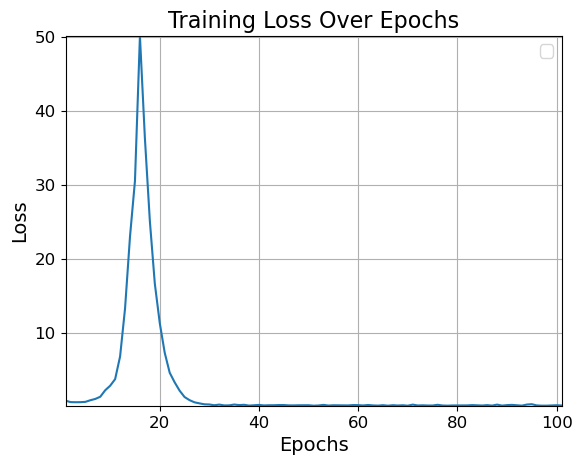

In [329]:
import matplotlib.pyplot as plt
plt.plot(epochs,losses)

plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.grid(True)

# Ticks and limits
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([1, 101])
plt.ylim([min(losses) - 0.0001, max(losses) + 0.0001])

# Adding legend
plt.legend(fontsize=12)
plt.savefig('training_loss_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [322]:
target_labels.cpu().detach().numpy().shape

(999,)

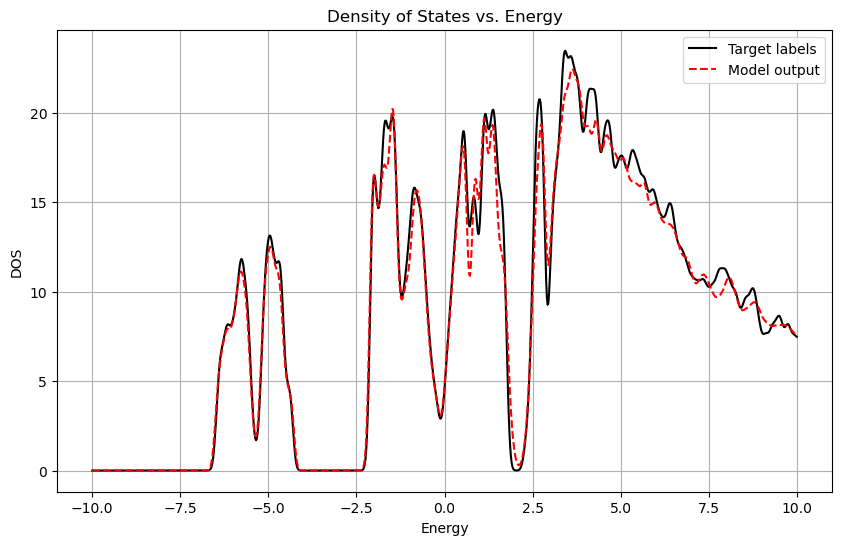

In [336]:
x = np.linspace(-10, 10, 999) 
plt.figure(figsize=(10, 6))
plt.plot(x, target_labels.cpu().detach().numpy(),color='black', label = 'Target labels')
plt.plot(x, output.cpu().detach().numpy(),color='red', linestyle= '--', label = 'Model output')
plt.xlabel('Energy')
plt.ylabel('DOS')
plt.title('Density of States vs. Energy')
plt.legend()
plt.grid(True)
plt.show()

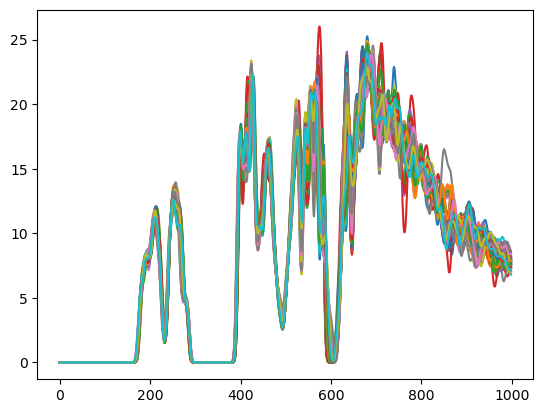

In [338]:
for i in range(80):
    plt.plot(dataset[i].y,label='Target')
plt.show()